In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import scipy.stats

from scipy.stats import lognorm, gamma, weibull_min, alpha, invweibull
from scipy.optimize import minimize

from collections import OrderedDict
import math
from itertools import izip
from copy import deepcopy

In [131]:
mpl.rcParams['figure.figsize'] = (9.0, 5.0)  # default size of plots
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

In [9]:
# %config InlineBackend.figure_format='svg'
# %config InlineBackend.figure_format='retina'

In [10]:
txt_filename = ("/Users/robina/Soolin_Users_L1JEC_CMSSW_8_0_0_pre6_Local/L1Trigger/L1JetEnergyCorrections/"
                "Stage2_HF_QCDFlatSpring15BX25HCALFix_12Feb_85a0ccf_noJEC_fixedPUS/rsp_clean.txt")

with open(txt_filename) as f:
    rsp = [float(x) for x in f]

In [11]:
rsp = np.array(rsp)
rspInv = 1./rsp

In [12]:
txt_filename = ("/Users/robina/Soolin_Users_L1JEC_CMSSW_8_0_0_pre6_Local/L1Trigger/L1JetEnergyCorrections/"
                "Stage2_HF_QCDFlatSpring15BX25HCALFix_12Feb_85a0ccf_noJEC_fixedPUS/rsp_ptRef102to106_clean.txt")

with open(txt_filename) as f:
    rspHigh = [float(x) for x in f]

In [13]:
rspHigh = np.array(rspHigh)
rspHighInv = 1./rspHigh

# Scipy fit functions

Note that we can find a fit for response **or** 1/response - it doesn't matter, since we can transform to either space trivially via the Jacobian.

## Lower ptRef bin (10  - 14 Gev) 

##  response

In [185]:
fit_fns_small = OrderedDict()
fit_fns_small["Normal"] = dict(fn=scipy.stats.norm)
fit_fns_small["Lognormal"] = dict(fn=scipy.stats.lognorm)
fit_fns_small["Gamma"] = dict(fn=scipy.stats.gamma)
fit_fns_small["Weibull min"] = dict(fn=scipy.stats.weibull_min)
fit_fns_small["Inv. weibull"] = dict(fn=scipy.stats.invweibull)
fit_fns_small["Inv. gauss"] = dict(fn=scipy.stats.invgauss)
fit_fns_small["Fisk"] = dict(fn=scipy.stats.fisk)
fit_fns_small["Burr"] = dict(fn=scipy.stats.burr)
fit_fns_small["Inv. gamma"] = dict(fn=scipy.stats.invgamma)
fit_fns_small["Chi2"] = dict(fn=scipy.stats.chi2)

In [162]:
fit_fns =  OrderedDict()
fit_fns["Beta"] = dict(fn=scipy.stats.beta)
fit_fns["Betaprime"] = dict(fn=scipy.stats.betaprime)
fit_fns["Burr"] = dict(fn=scipy.stats.burr)
fit_fns["Chi"] = dict(fn=scipy.stats.chi)
fit_fns["Chi2"] = dict(fn=scipy.stats.chi2)
fit_fns["Exponnorm"] = dict(fn=scipy.stats.exponnorm)
fit_fns["Exponweib"] = dict(fn=scipy.stats.exponweib)
fit_fns["F"] = dict(fn=scipy.stats.f)
fit_fns["Fatiguelife"] = dict(fn=scipy.stats.fatiguelife)
fit_fns["Fisk"] = dict(fn=scipy.stats.fisk)
fit_fns["Frechet_l"] = dict(fn=scipy.stats.frechet_l)
fit_fns["Genlogistic"] = dict(fn=scipy.stats.genlogistic)
fit_fns["Genextreme"] = dict(fn=scipy.stats.genextreme)
fit_fns["Gamma"] = dict(fn=scipy.stats.gamma)
fit_fns["Gengamma"] = dict(fn=scipy.stats.gengamma)
fit_fns["Gumbel_r"] = dict(fn=scipy.stats.gumbel_r)
fit_fns["Invgamma"] = dict(fn=scipy.stats.invgamma)
fit_fns["Invgauss"] = dict(fn=scipy.stats.invgauss)
fit_fns["Invweibull"] = dict(fn=scipy.stats.invweibull)
fit_fns["Johnsonsb"] = dict(fn=scipy.stats.johnsonsb)
fit_fns["Johnsonsu"] = dict(fn=scipy.stats.johnsonsu)
fit_fns["Kstwobign"] = dict(fn=scipy.stats.kstwobign)
fit_fns["Lognorm"] = dict(fn=scipy.stats.lognorm)
fit_fns["Mielke"] = dict(fn=scipy.stats.mielke)
fit_fns["Norm"] = dict(fn=scipy.stats.norm)
fit_fns["Pearson3"] = dict(fn=scipy.stats.pearson3)
fit_fns["Powerlognorm"] = dict(fn=scipy.stats.powerlognorm)
fit_fns["Rayleigh"] = dict(fn=scipy.stats.rayleigh)
fit_fns["Rice"] = dict(fn=scipy.stats.rice)
fit_fns["Recipinvgauss"] = dict(fn=scipy.stats.recipinvgauss)
fit_fns["Weibull_max"] = dict(fn=scipy.stats.weibull_max)

In [15]:
def get_bin_centers(bins):
    return np.array([0.5 * (bins[i]+bins[i+1]) for i in range(len(bins)-1)])

In [196]:
def plot_multiple_fits(data, fit_fns, x_label, x_range, n_fit_std=10):
    """Plot multiple fits to the data, show all.

    data: numpy.array. Data to fit to. 
    fit_fns: dict[name, dict]. Function to fit, and name.
    x_label: str. Label for x axis
    x_range: list[min, max]. Range of x axis
    """
    ncols = 3
    nrows = int(math.ceil(len(fit_fns)/2.))
    fig = plt.gcf()
    fig.set_size_inches(ncols * 5, nrows * 5)
    plt.subplots_adjust(hspace=0.5)

    x_val = np.linspace(x_range[0], x_range[1], 100)

    for i_plt, (fn_name, fit_fn_dict) in enumerate(fit_fns.iteritems(), 1):
        print "Doing", fn_name
        #         if i_plt == 2:
#             break
        plt.subplot(nrows, ncols, i_plt)
        ax = plt.gca()
        ax.set_title(fn_name + ' fit')
        ax.set_xlabel(x_label)

        # apply optional cut to data
        mean = data.mean()
        std = data.std()
        mask = (data < mean + (std*n_fit_std)) & (data > mean-(std*n_fit_std))
        data = data[mask]
#         ax.set_yscale('log')

        # plot hist
        n, bins, patches = ax.hist(data, bins=40, range=x_range, normed=True)

        # fit
        try:
            fit_results = fit_fn_dict['fn'].fit(data)
        except NotImplementedError:
            continue
        print fit_results
        has_shape_param = len(fit_results) >= 3
        loc = fit_results[-2]
        scale = fit_results[-1]
        shape = None
        if has_shape_param:
            shape = fit_results[:-2]

        fit_fn_dict['shape'] = shape
        fit_fn_dict['loc'] = loc
        fit_fn_dict['scale'] = scale
            
        if has_shape_param:
            frozen_fit = fit_fn_dict['fn'](*shape, loc=loc, scale=scale)
        else:
            frozen_fit = fit_fn_dict['fn'](loc=loc, scale=scale)
        
        # get mode for fitted fn
        ave = 0.5*(x_range[0]+x_range[1])
        max_result = minimize(lambda x: -1. * frozen_fit.pdf(x), x0=ave)
        mode = max_result.x[0]

        # get mode for proper fn for (1/x) - include jacobian
        max_result_inv = minimize(lambda x: -1. * np.power(1./x, 2) * frozen_fit.pdf(1./x), x0=1./ave)
        mode_inv = max_result_inv.x[0]
        
        # do chi2 test
        bc = get_bin_centers(bins)
        predicted = np.array([frozen_fit.pdf(x) for x in bc])
        ddof = len(shape)+2 if has_shape_param else 2
        chisq, p = scipy.stats.chisquare(n, f_exp=predicted, ddof=ddof)
        fit_fn_dict['chi2'] = chisq
        fit_fn_dict['p'] = p
        print shape, loc, scale, mode, mode_inv, chisq, p
        
        # plot fitted fn
        y_val = frozen_fit.pdf(x_val)
        ax.plot(x_val, y_val, 'r', linewidth=3)
        ax.text(0.4, 0.65, 
                'mode = %.4f\n1/mode = %.4f\nmode (1/rsp) = %.4f\nchi2 = %.3f, p=%.3f' % (mode, 1./mode, mode_inv, chisq, p), 
                transform=ax.transAxes, fontsize=12)

        # arrow for mode
        ax.vlines(mode, ax.get_ylim()[0], ax.get_ylim()[1], colors=['red'], linestyles='dashed')

Doing Beta
(3.0230300333300359, 1782041379998.6787, 0.0061096755142609205, 267936968994.44775)
(3.0230300333300359, 1782041379998.6787) 0.00610967551426 267936968994.0 0.310280404338 1.64482798646 0.591062013024 1.0
Doing Betaprime
(16.344245616259741, 10.569644063270601, -0.15111300234983244, 0.35620154983819408)
(16.344245616259741, 10.569644063270601) -0.15111300235 0.356201549838 0.321299454005 1.80203286093 0.22420666793 1.0
Doing Burr
(3.7989036602894894, 0.57362014248279913, 0.0091212733978884037, 0.50023249918693202)
(3.7989036602894894, 0.57362014248279913) 0.00912127339789 0.500232499187 0.354829293068 1.91119243152 0.0978116451796 1.0
Doing Chi
(1.6223851355228081, 0.03092780207862468, 0.39407158959909694)
(1.6223851355228081,) 0.0309278020786 0.394071589599 0.341816344928 1.52084801998 inf 0.0
Doing Chi2
(6.6640346313361079, -0.0042681556087542311, 0.069315821308007508)
(6.6640346313361079,) -0.00426815560875 0.069315821308 0.319023374245 1.67150123797 0.476259795836 1.0
Do

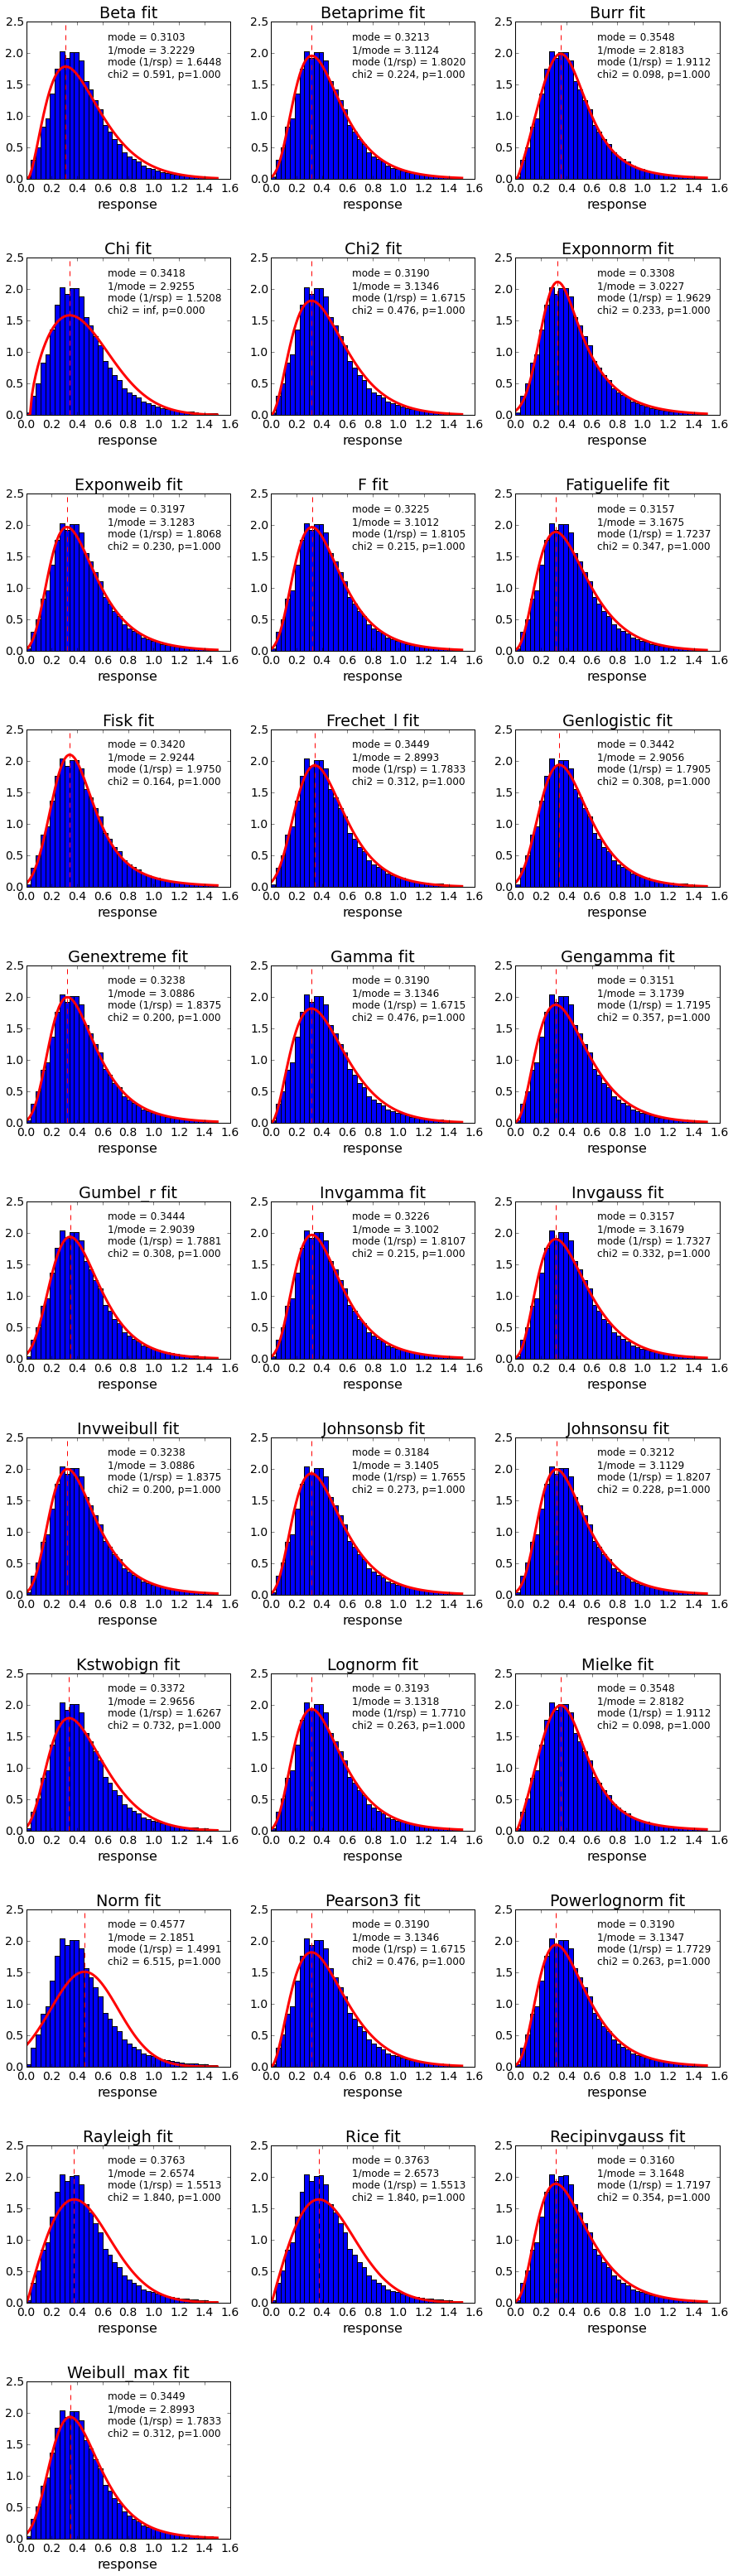

In [199]:
rsp_fit_fns = deepcopy(fit_fns)
plot_multiple_fits(rsp, rsp_fit_fns, 'response', [0, 1.5])

In [158]:
def print_ordered_fit_fn(d):
    tmp = OrderedDict(sorted(d.items(), key=lambda t: t[1]))
    for k, v in tmp.iteritems():
        print k, v['chi2'], v['p']

In [200]:
print_ordered_fit_fn(rsp_fit_fns)

Burr 0.0978116451796 1.0
Mielke 0.0978159600107 1.0
Fisk 0.16379384059 1.0
Genextreme 0.200485971932 1.0
Invweibull 0.200497670702 1.0
F 0.215024069555 1.0
Invgamma 0.215026342036 1.0
Betaprime 0.22420666793 1.0
Johnsonsu 0.228140502355 1.0
Exponweib 0.230204187685 1.0
Exponnorm 0.23276828022 1.0
Powerlognorm 0.263131296688 1.0
Lognorm 0.263458108913 1.0
Johnsonsb 0.272677858578 1.0
Genlogistic 0.307516986026 1.0
Gumbel_r 0.308116725833 1.0
Frechet_l 0.311934095635 1.0
Weibull_max 0.311934095635 1.0
Invgauss 0.332044166602 1.0
Fatiguelife 0.347020050945 1.0
Recipinvgauss 0.353605186613 1.0
Gengamma 0.356545059663 1.0
Pearson3 0.476238413733 1.0
Gamma 0.476256518464 1.0
Chi2 0.476259795836 1.0
Beta 0.591062013024 1.0
Kstwobign 0.73160117721 1.0
Rice 1.83950265135 1.0
Rayleigh 1.83950799224 1.0
Norm 6.51539046798 0.999999994874
Chi inf 0.0


In [86]:
def calc_hist_fn_diff(n, bins, fn):
    centers = get_bin_centers(bins)
    fn_vals = np.array([fn(x) for x in centers])
    return fn_vals - n

In [173]:
def plot_cdf(data, fit_fns, x_label, x_range):
    """Plot CDF for data compared with fit_fns. Also draws residuals plot."""
    fig = plt.figure()
    fig.set_size_inches(10, 8)
    gs = gridspec.GridSpec(2, 1, height_ratios=[2.2, 1])
    gs.update(hspace=0.1)
    ax1 = fig.add_subplot(gs[0])

    n, bins, _ = ax1.hist(data, normed=True, cumulative=True, bins=40, 
                          range=x_range, histtype='step', color='black', linewidth=2)
    bin_centers = get_bin_centers(bins)
    
    x = np.linspace(x_range[0], x_range[1], 100)
    colors = np.random.rand(len(fit_fns))
    #     colors = ['red', 'dodgerblue', 'blue', 'orange', 
#               'fuchsia', 'mediumpurple', 'springgreen', 'forestgreen']
#     colors = ['red'] * len(fit_fns)
#     if len(colors) < len(fit_fns):
#         new_colors = list(np.random.rand(len(fit_fns) - len(colors)))
#         colors.extend(list(new_colors))
    diff_vals = []
    for color, (fn_name, fit_fn_dict) in izip(colors, fit_fns.iteritems()):
        loc=fit_fn_dict['loc']
        scale=fit_fn_dict['scale']
        if fit_fn_dict['shape']:
            fn_freeze = fit_fn_dict['fn'](*fit_fn_dict['shape'], loc=loc, scale=scale)
        else:
            fn_freeze = fit_fn_dict['fn'](loc=loc, scale=scale)
        y_vals = fn_freeze.cdf(x)
        diff_vals.append(calc_hist_fn_diff(n, bins, fn_freeze.cdf))
        ax1.plot(x, y_vals, color=str(color), linewidth=2, label=fn_name)                                                    
    ax1.legend(loc=4, fontsize=12)
    ax1.set_ylabel('CDF')
    
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    for color, diff in izip(colors, diff_vals):
        ax2.plot(bin_centers, diff, 'd-', color=str(color))
    ax2.set_xlabel(x_label)
    ax2.set_ylabel('Fit - hist')
    ax2.hlines(0, ax2.get_xlim()[0], ax2.get_xlim()[1], linestyle='dashed')
    ax2.grid(which='both')
    plt.setp(ax1.get_xticklabels(), visible=False)        
        

[  2.32355432e-04   3.82921784e-01   5.47812497e-01   7.52306979e-01
   9.31384438e-02   5.47042104e-01   1.15064286e-01   2.52607285e-01
   7.43743009e-01   5.30664325e-01   5.38595516e-01   5.00225991e-01
   3.32799209e-01   8.07367742e-01   4.67412246e-01   9.14904634e-01
   3.12690332e-02   9.94485934e-01   1.57607027e-01   9.48517456e-01
   9.68778440e-01   9.49673913e-01   3.03957568e-01   3.16458225e-02
   8.41726710e-01   9.09595506e-01   8.09398313e-01   1.47071983e-01
   9.29326989e-01   4.63523394e-01   5.04208601e-01]


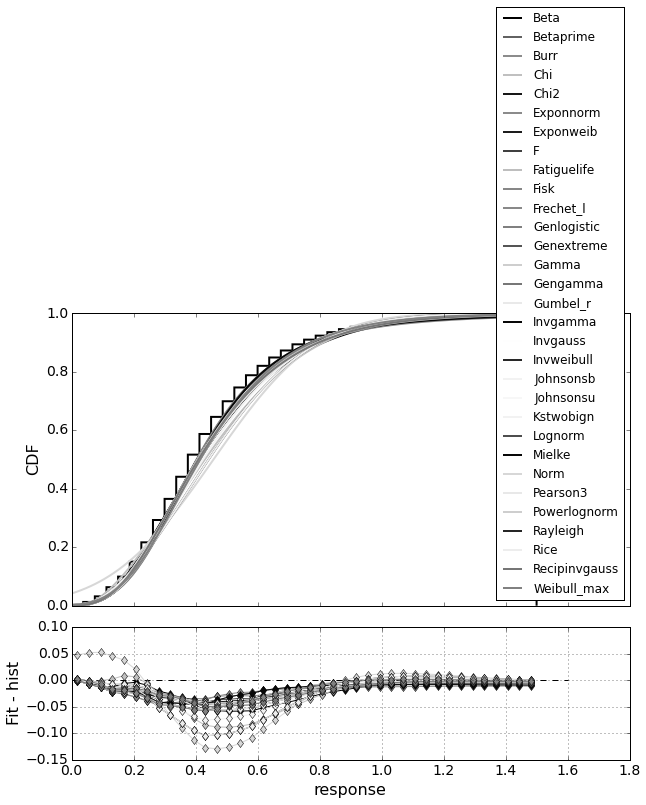

In [201]:
plot_cdf(rsp, rsp_fit_fns, 'response', [0, 1.5])

## 1 / response

Doing Beta
(1.5464057176090531, 57530.425713092292, 0.49989595424279998, 102735.83814050592)
(1.5464057176090531, 57530.425713092292) 0.499895954243 102735.838141 1.47565569954 0.214394232421 nan nan
Doing Betaprime
(34.081921835496459, 3.7895868109746691, -0.06153832774798168, 0.25948925010943957)
(34.081921835496459, 3.7895868109746691) -0.061538327748 0.259489250109 1.7307681233 0.307665471785 0.12954734095 1.0
Doing Burr
(2.4933812341237327, 1.0795428977672512, 0.37423363940865045, 2.0031584574413754)
(2.4933812341237327, 1.0795428977672512) 0.374233639409 2.00315845744 1.87188287306 0.332605356684 nan nan
Doing Chi
(0.91656816143329745, 0.50001167527261747, 4.0849170647648254)
(0.91656816143329745,) 0.500011675273 4.08491706476 4.0 0.169511748049 nan nan
Doing Chi2
(3.4191275989512917, 0.49959989977113195, 0.78021083736103813)
(3.4191275989512917,) 0.499599899771 0.780210837361 1.60681924489 0.228783244282 nan nan
Doing Exponnorm
(5.6704556095259742, 1.1332564626787449, 0.35869932

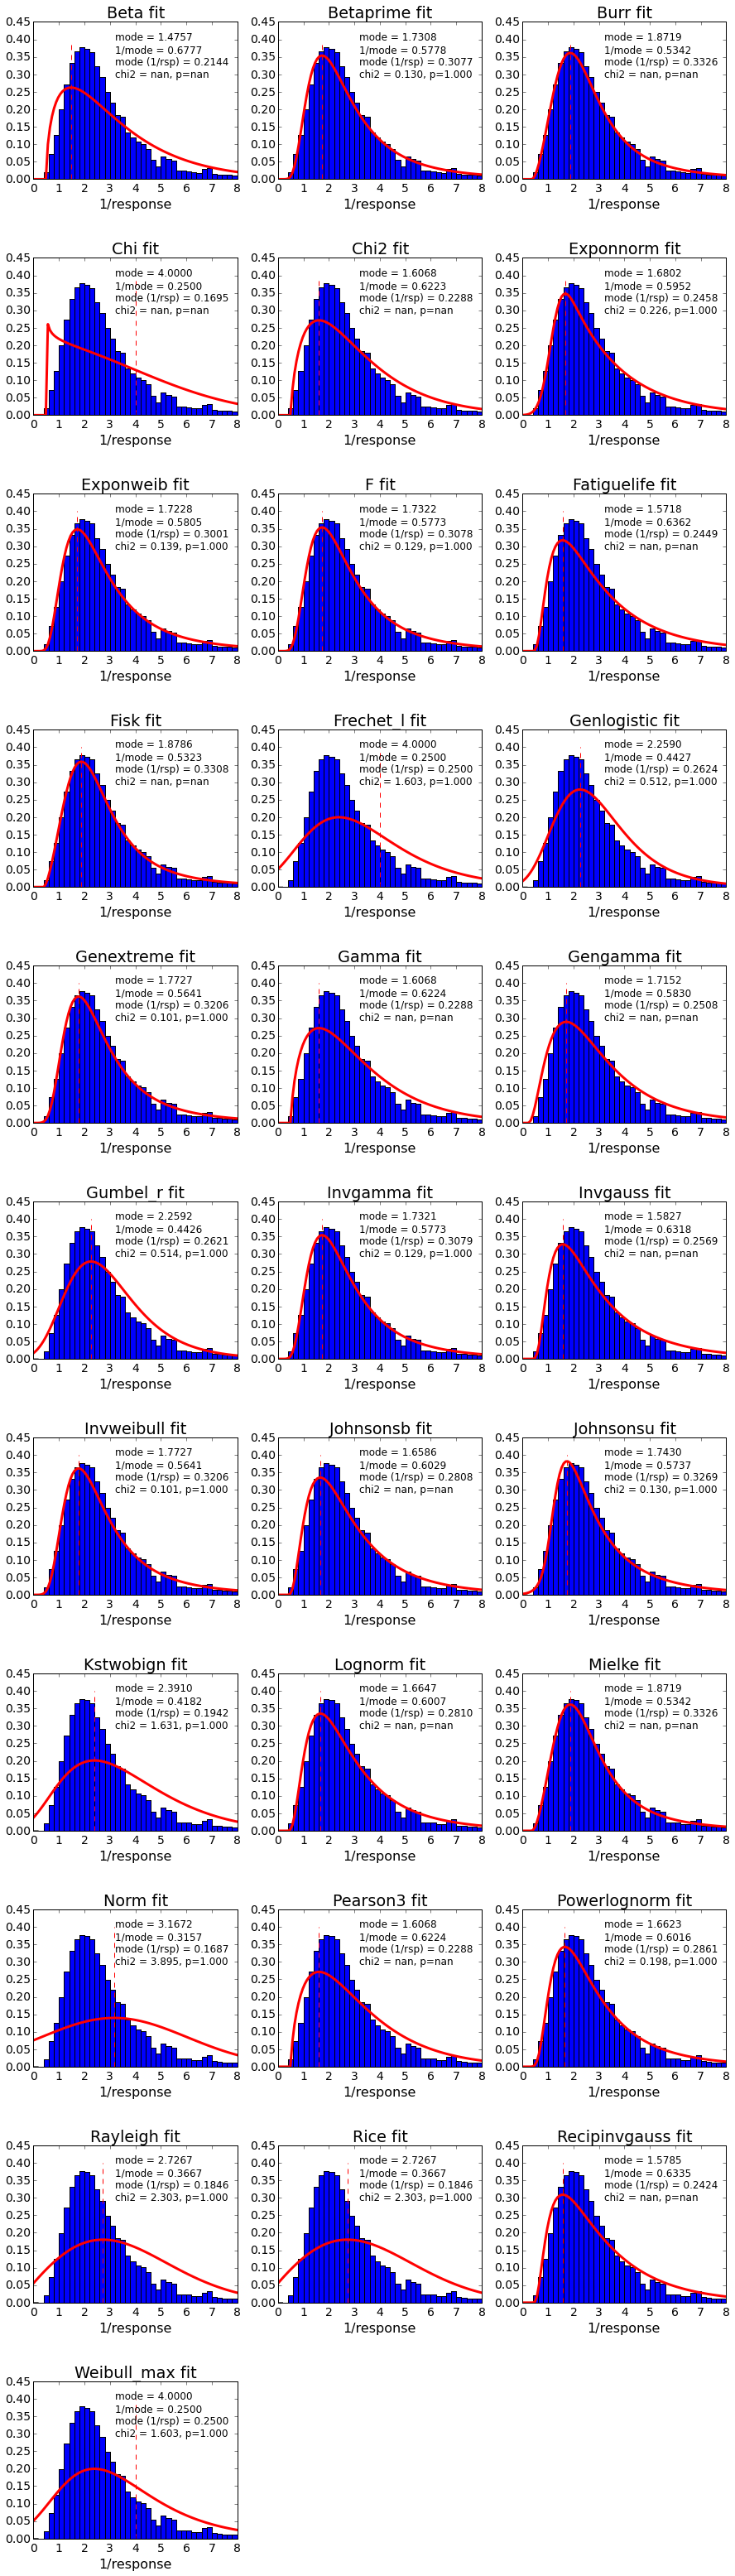

In [202]:
rspInv_fit_fns = deepcopy(fit_fns)
plot_multiple_fits(rspInv, rspInv_fit_fns, '1/response', [0, 8])

In [188]:
def apply_fit_to_inverse(data, fit_fn, fn_name):
    """Fit to response, apply function (wiht jacobian) to inverse response."""
    plt.gcf().set_size_inches(14, 6)
    plt.subplot(1, 2, 1)
    ax = plt.gca()
    
    # cuts for data
    mean = data.mean()
    std = data.std() * 10
    mask = (data < (mean+std)) & (data>(mean-std))
    
    n, bins, _ = ax.hist(data[mask], bins=40, range=[0, 1.5], normed=True)
    fit_results = fit_fn.fit(data[mask])
    shape = None
    loc = fit_results[-2]
    scale = fit_results[-1]
    if len(fit_results) >=3:
        shape = fit_results[0:-2]
    print shape, loc, scale
    # plot fitted fn
    x_val = np.arange(0.01, 1.5, 0.01)
    ax.plot(x_val, fit_fn.pdf(x_val, *shape, loc=loc, scale=scale), 'r', linewidth=3)
    ax.set_title('%s fit' % fn_name)
    ax.set_xlabel('response')

    # get mode
    max_result = minimize(lambda x: -1 * fit_fn.pdf(x, *shape, loc=loc, scale=scale), x0=0.75)
    mode = max_result.x[0]
    
    # do chi2 test
    bc = get_bin_centers(bins)
    predicted = fit_fn.pdf(bc, *shape, loc=loc, scale=scale)
    ddof = len(shape)+2
    chisq, p = scipy.stats.chisquare(n, f_exp=predicted, ddof=ddof)
    ax.text(0.5, 0.7, 'mode = %.4f\n1/mode = %.4f\nchi2 = %.4f\np = %.4f' % (mode, 1./mode, chisq, p), 
            transform=ax.transAxes)
    
    # plot 1/response
    plt.subplot(1, 2, 2)
    ax = plt.gca()
    n, bins, _ = ax.hist(1./data, bins=40, range=[0,8], normed=True)
    x_val = np.arange(0.01, 8, 0.01)
    ax.plot(x_val, np.power((1./x_val), 2) * fit_fn.pdf(1./x_val, *shape, loc=loc, scale=scale), 
            'r', linewidth=3)

    # do chi2 test
    bc = get_bin_centers(bins)
    predicted = np.power((1./bc), 2) * fit_fn.pdf(1./bc, *shape, loc=loc, scale=scale)
    dof = 3
    chisq, p = scipy.stats.chisquare(n, f_exp=predicted, ddof=dof)
    
    ax.set_title('Using fit params')
    ax.set_xlabel('1 / response')
    mode = 1.0
    ax.text(0.5, 0.7, 'chi2 = %.4f\np = %.4f' % (chisq, p), transform=ax.transAxes)

We can check how well the distribution models response, by plotting it on top of 1/response (with necessary Jacobian transform) and calcualting chi2.

(0.42484031636902841,) -0.124175829665 0.53119838748


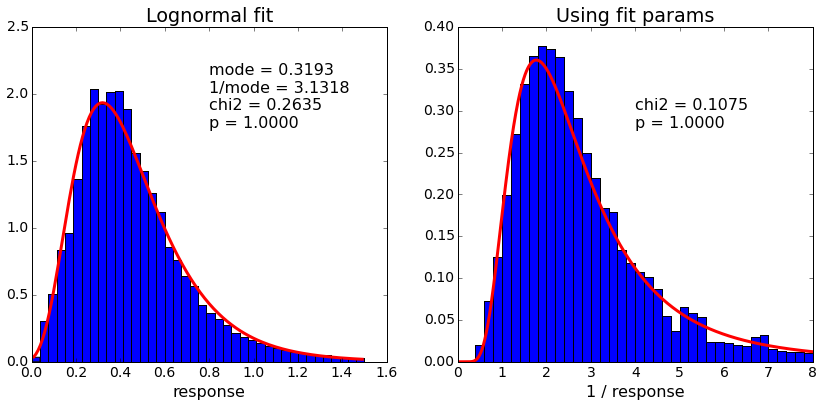

In [189]:
apply_fit_to_inverse(rsp, scipy.stats.lognorm, 'Lognormal')

(3.8624814633240279,) -0.08640309716 0.491336578023


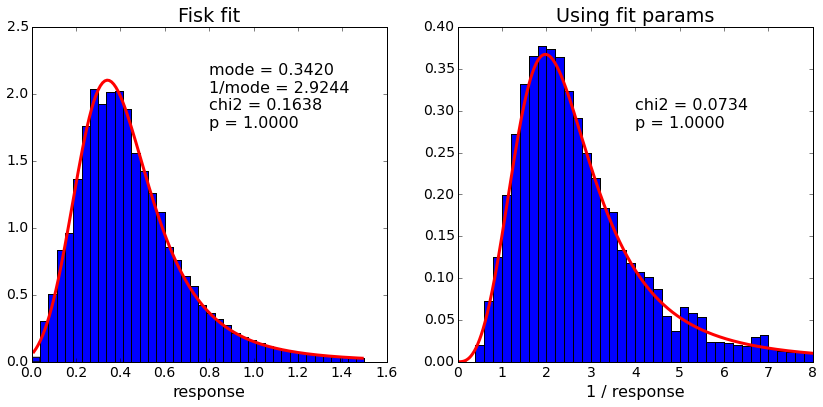

In [190]:
apply_fit_to_inverse(rsp, scipy.stats.fisk, 'Fisk')

(2.2999810196267463,) 0.217451928964 0.104436539053


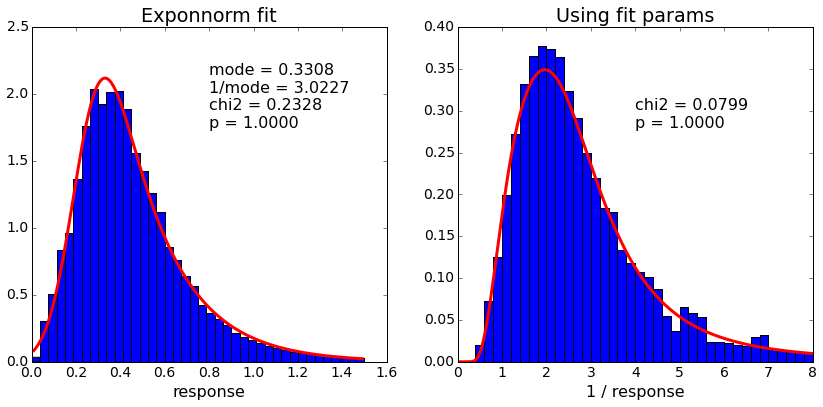

In [177]:
apply_fit_to_inverse(rsp, scipy.stats.exponnorm, 'Exponnorm')

(3.7989036602894894, 0.57362014248279913) 0.00912127339789 0.500232499187


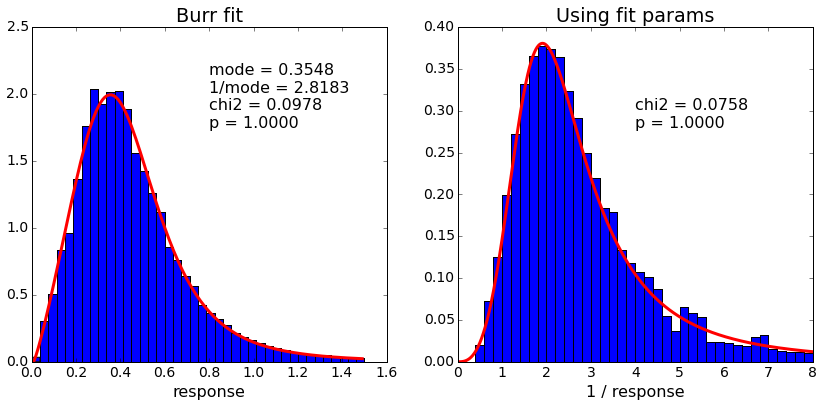

In [191]:
apply_fit_to_inverse(rsp, scipy.stats.burr, 'Burr')

## Higher ptRef bin (102 - 106 GeV)

Doing Beta
(27.627921563883277, 1876.4947154228075, -0.21949602920468314, 53.681175882775648)
(27.627921563883277, 1876.4947154228075) -0.219496029205 53.6811758828 0.531989729756 1.64571558527 7.0212762459 0.999999914071
Doing Betaprime
(108.07417236509849, 97.26478080922584, -0.48266578920599124, 0.9278029051891068)
(108.07417236509849, 97.26478080922584) -0.482665789206 0.927802905189 0.528314198499 1.66081967842 4.12541452624 0.99999999997
Doing Burr
(9.735131199234953, 0.71372751371132259, -0.13152277821839148, 0.71833840441299757)
(9.735131199234953, 0.71372751371132259) -0.131522778218 0.718338404413 0.544543818258 1.70133703157 0.193231977087 1.0
Doing Chi
(9.9014907005457964, -0.087650378980587432, 0.21095450730176082)
(9.9014907005457964,) -0.0876503789806 0.210954507302 0.541740110298 1.61845798211 56.7816311629 0.0150986400659
Doing Chi2
(58.999349670987954, -0.23743325161347356, 0.01350278292263286)
(58.999349670987954,) -0.237433251613 0.0135027829226 0.532216585349 1.646

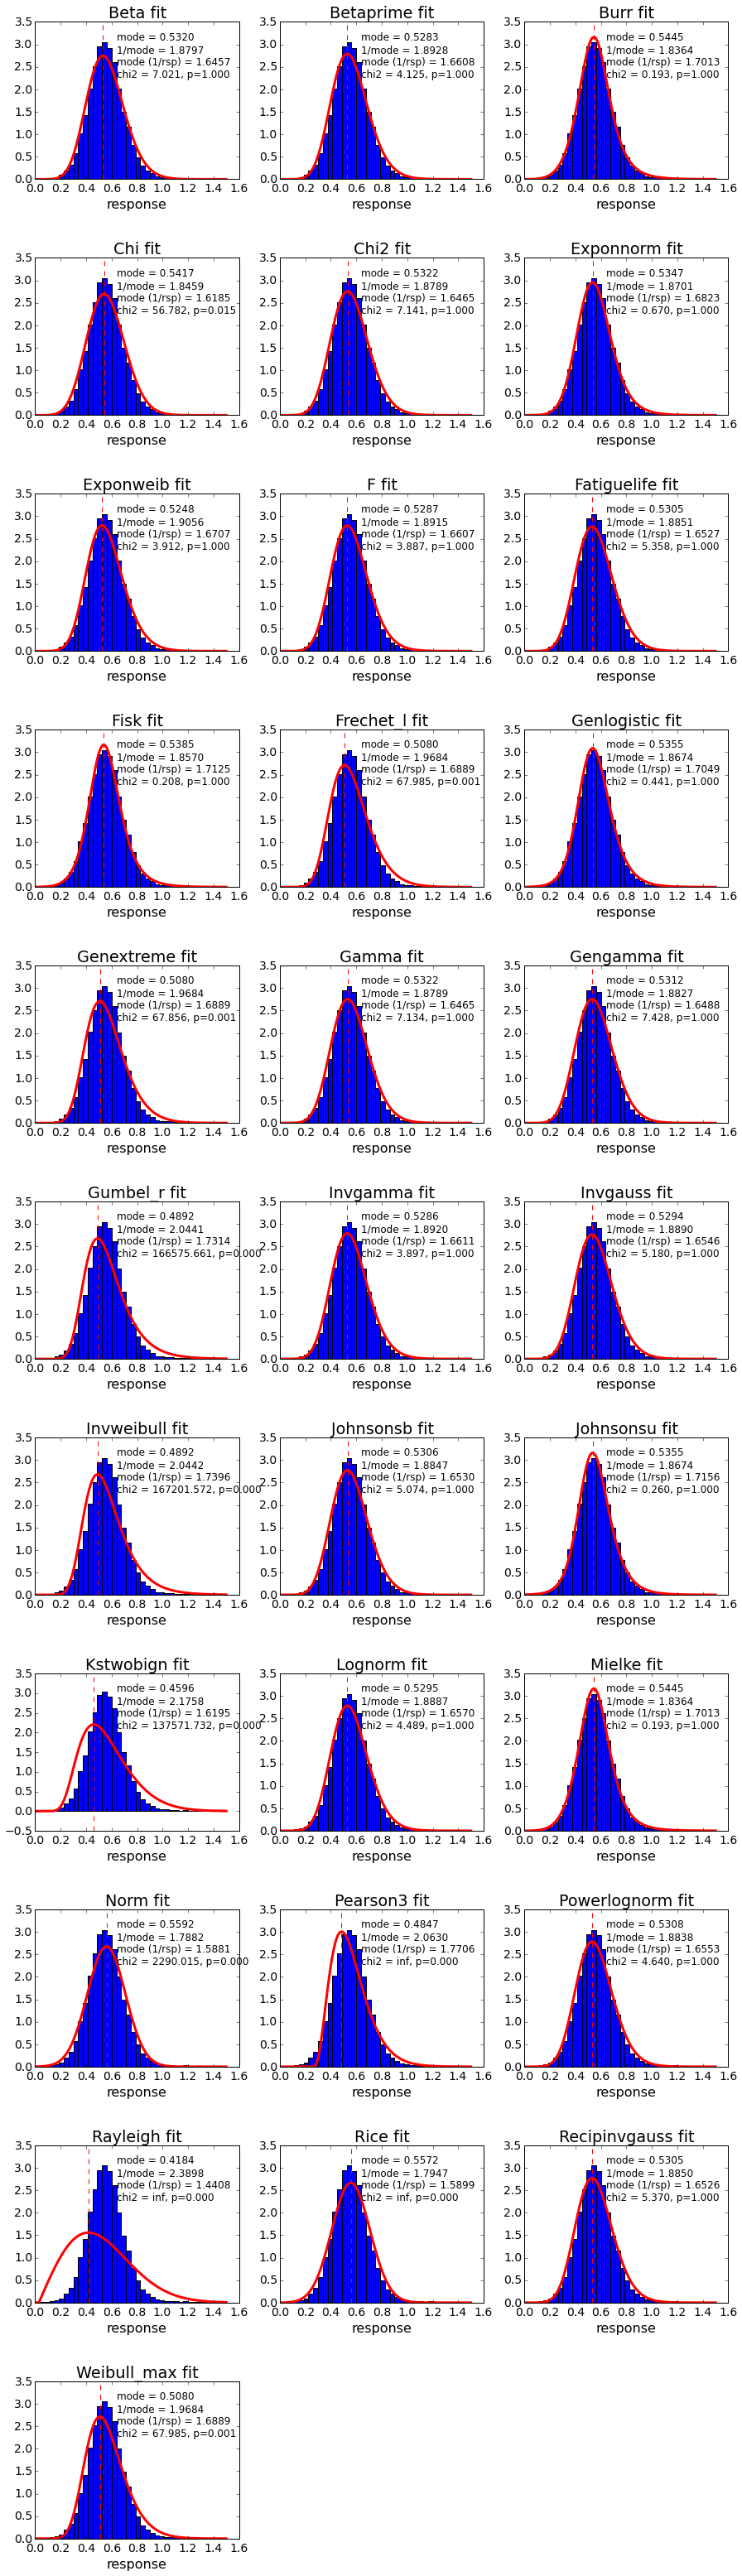

In [197]:
rspHigh_fit_fns = deepcopy(fit_fns)
plot_multiple_fits(rspHigh, rspHigh_fit_fns, 'response', [0, 1.5])

In [198]:
print_ordered_fit_fn(rspHigh_fit_fns)

Burr 0.193231977087 1.0
Mielke 0.193234079093 1.0
Fisk 0.207734287854 1.0
Johnsonsu 0.260199190997 1.0
Genlogistic 0.441079471134 1.0
Exponnorm 0.669922284801 1.0
F 3.88720434921 0.999999999988
Invgamma 3.89720751422 0.999999999996
Exponweib 3.9117761173 0.999999999987
Betaprime 4.12541452624 0.99999999997
Lognorm 4.48864525958 0.999999999961
Powerlognorm 4.63992428165 0.999999999814
Johnsonsb 5.07359780883 0.999999999274
Invgauss 5.18004555049 0.999999999627
Fatiguelife 5.35768910301 0.999999999371
Recipinvgauss 5.37011905148 0.999999999348
Beta 7.0212762459 0.999999914071
Gamma 7.13443525006 0.999999952622
Chi2 7.14057720769 0.999999952021
Gengamma 7.42810393804 0.999999809608
Chi 56.7816311629 0.0150986400659
Genextreme 67.8564287802 0.00103430458066
Frechet_l 67.9845310818 0.00100016691835
Weibull_max 67.9845310818 0.00100016691835
Norm 2290.01488106 0.0
Kstwobign 137571.732163 0.0
Gumbel_r 166575.66067 0.0
Invweibull 167201.572367 0.0
Pearson3 inf 0.0
Rayleigh inf 0.0
Rice inf 0.0

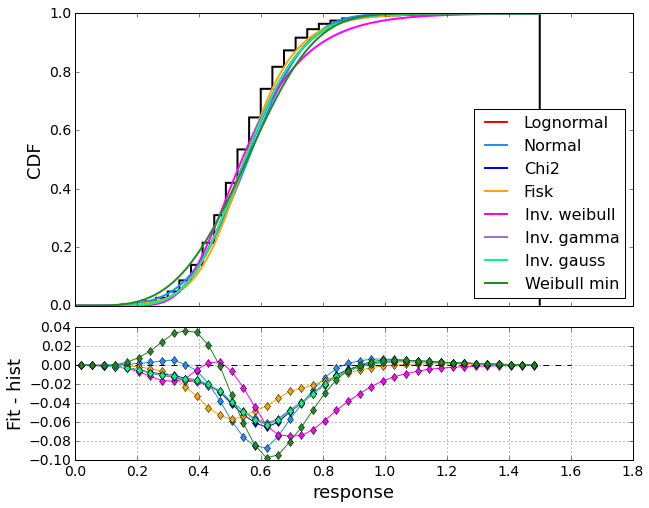

In [93]:
plot_cdf(rspHigh, rspHigh_fit_fns, 'response', [0, 1.5])

/Users/robina/.virtualenvs/ipywidgets/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in divide


nan 27
Lognormal : 0.304674920757 0.198004172102 1.64392906104 1.69620101796 0.508009324551 nan nan
1.59796182402 28
Normal : None 1.92182441004 0.586088755972 1.92182418544 0.448448827332 1.59796182402 0.999999999999
nan 27
Chi2 : 18.8545189105 0.294434322436 0.0862995549542 1.74897203024 0.489127673846 nan nan
nan 27
Fisk : 5.74138742917 0.285505732273 1.5393932521 1.73337104536 0.528583859059 nan nan
1569.81339683 27
Inv. weibull : 44.8064669734 -17.0940205659 18.7673690896 1.66410553488 0.524936305728 1569.81339683 0.0
23556.2653776 27
Inv. gamma : 16.8011796389 -0.151153579144 32.6919510291 1.68535111794 0.515882312627 23556.2653776 0.0
nan 27
Inv. gauss : 0.0858855399728 0.0975368219453 21.234993145 1.70143340715 0.503695000403 nan nan
nan 27
Weibull min : 2.70185727828 0.304737528708 1.80626640259 1.82698586259 0.438842803887 nan nan
nan 27
Gamma : 9.44391368153 0.294310055941 0.172280955828 1.74903587096 0.48924047942 nan nan


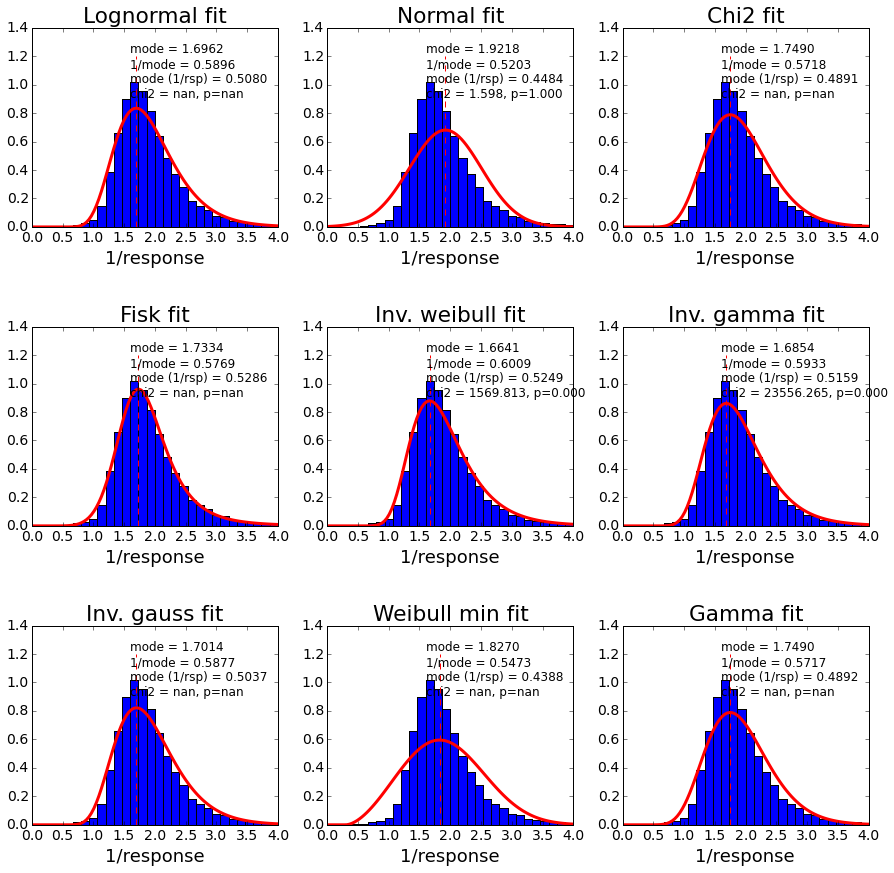

In [94]:
rspHighInv_fit_fns = deepcopy(fit_fns)
plot_multiple_fits(rspHighInv, rspHighInv_fit_fns, '1/response', [0, 4])

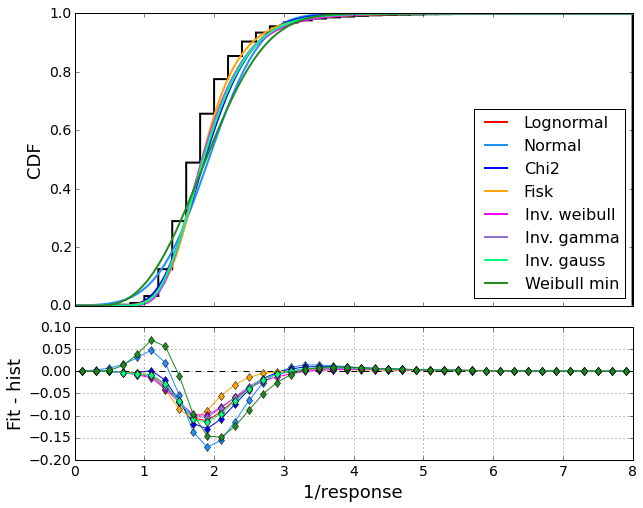

In [95]:
plot_cdf(rspHighInv, rspHighInv_fit_fns, '1/response', [0, 8])

0.154298584152 -0.395180479058 0.943463158564


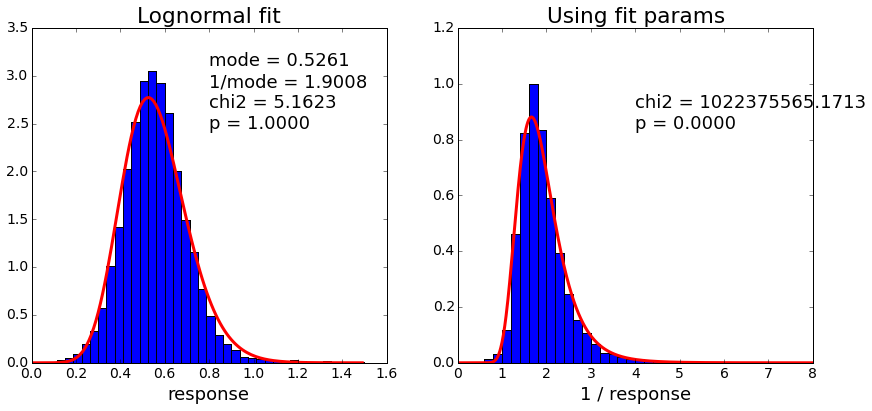

In [72]:
apply_fit_to_inverse(rspHigh, scipy.stats.lognorm, 'Lognormal')

13.0522913071 -0.488558211959 1.03842389756


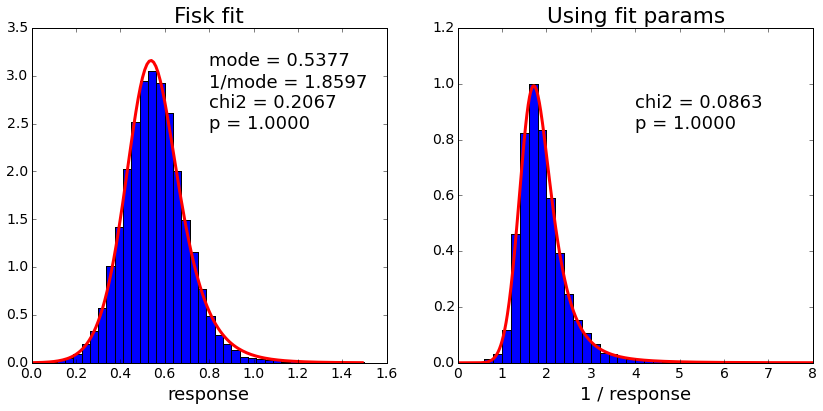

In [73]:
apply_fit_to_inverse(rspHigh, scipy.stats.fisk, 'Fisk')

(0.87557410318578643,) 0.463330557512 0.110058418106


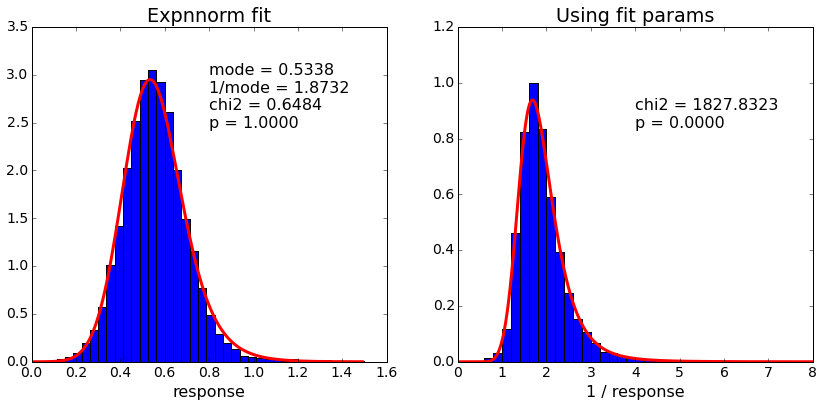

In [179]:
apply_fit_to_inverse(rspHigh, scipy.stats.exponnorm, 'Expnnorm')

(9.4933700313921499, 0.70746680887276558) -0.113873841711 0.701651954968


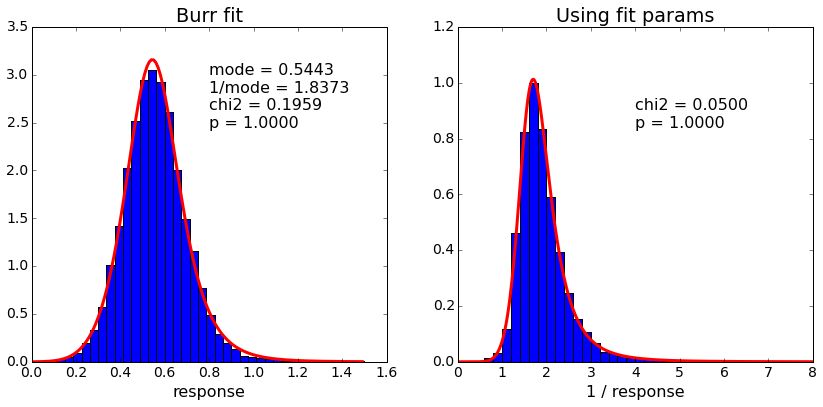

In [180]:
apply_fit_to_inverse(rspHigh, scipy.stats.burr, 'Burr')

# Trying my own fitting

In [99]:
# For the function
x = np.arange(0.01,10,0.01)


def my_lognorm(x, N, m, theta, sigma):
    x = x[x>theta]
    exp = np.power(np.log((x-theta)/m), 2) / (2 * np.power(sigma, 2))
    result = (N * (x - theta) / ( sigma * np.sqrt(2 * np.pi))) * np.exp(-1. * exp)
    return x, result

def my_gamma(x):
    pass

def my_fisk(x, a, b, c):
    pass

In [100]:
my_lognorm(x=np.arange(0, 1, 0.2), N=1, m=1, theta=0, sigma=0.5)

(array([ 0.2,  0.4,  0.6,  0.8]),
 array([ 0.00089758,  0.05953092,  0.28407908,  0.57780375]))

In [101]:
def plot_hist_fn(hist_data, bins, xlim, x, fn, N, m, theta, sigma):
    plt.hist(hist_data, bins=bins, range=xlim)
    new_x, res = fn(x, N, m, theta, sigma)
    plt.plot(new_x, res, 'r-', linewidth=3)
    plt.xlim(xlim)

<function __main__.plot_hist_fn>

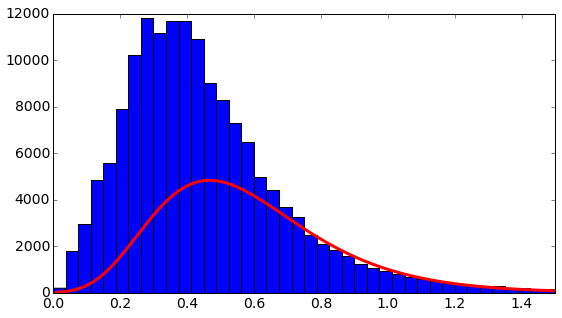

In [102]:
interact(plot_hist_fn, hist_data=fixed(rsp), bins=fixed(40), xlim=fixed([0, 1.5]), 
         x=fixed(x), 
         fn=fixed(my_lognorm), 
         N=widgets.FloatSlider(min=1, max=10000, step=50, value=5851, continuous_update=False), 
         m=widgets.FloatSlider(min=0, max=5, step=0.01, value=0.63, continuous_update=False), 
         theta=widgets.FloatSlider(min=-10, max=10, step=0.01, value=-0.23, continuous_update=False),
         sigma=widgets.FloatSlider(min=0, max=10, step=0.01, value=0.32, continuous_update=False))

<function __main__.plot_hist_fn>

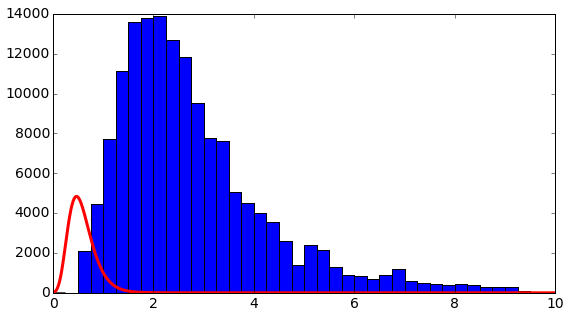

In [103]:
interact(plot_hist_fn, hist_data=fixed(rspInv), bins=fixed(40), xlim=fixed([0, 10]), 
         x=fixed(x), 
         fn=fixed(my_lognorm), 
         N=widgets.FloatSlider(min=1, max=50000, step=50, value=5851, continuous_update=True), 
         m=widgets.FloatSlider(min=0, max=5, step=0.01, value=0.63, continuous_update=True), 
         theta=widgets.FloatSlider(min=-10, max=10, step=0.01, value=-0.23, continuous_update=True),
         sigma=widgets.FloatSlider(min=0, max=10, step=0.01, value=0.32, continuous_update=True))

<function __main__.plot_fisk>

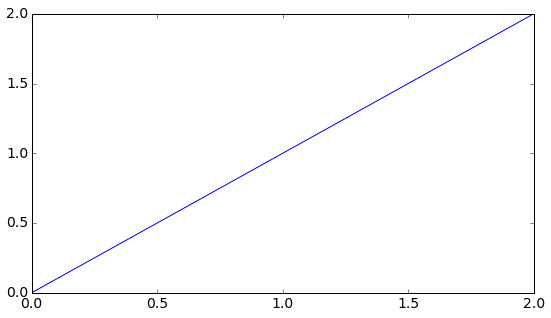

In [104]:
x = np.linspace(0, 2, 100)
def plot_fisk(a, b, c):
    plt.plot(x, x*a)
    
interact(plot_fisk, 
         a=widgets.FloatSlider(min=1, max=5, step=1, value=1, continuous_update=True),
         b=widgets.FloatSlider(min=1, max=5, step=1, value=1, continuous_update=True), 
         c=widgets.FloatSlider(min=1, max=5, step=1, value=1, continuous_update=True))